In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve 
import numpy as np
import pandas as pd

import string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
import tqdm

# 1. Preprocessing

In [2]:
# We define utility functions for text processing.

def removePunctuation(text):
    """
    Remove punctuation symbols and convert text to lowercase
    """
    return text.lower().translate(str.maketrans('', '', string.punctuation))

def removeStopWords(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([word for word in text.split() if word not in stopwords.words("english")])

def buildDictionary(texts):
    """
    Build the dictionary of words where key is the word and value is the index.
    """
    hashmap = {}
    for text in texts:
        for word in text.split():
            hashmap[word] = hashmap.get(word, 0) + 1
    return {w:i+1 for i, w in enumerate(list(hashmap.keys()))}

def calculateMaxSeqLen(texts):
    """
    Calculates the maximum sequence length found in the corpus
    """
    max_len = float('-inf')
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len

In [3]:
# Load the *.csv* file and filter the features that are useful for the problem:
data = pd.read_csv("C:/datasets/coronavirus/preprocessed_data.csv")

In [6]:
data = pd.concat((data[data["Sentiment"] == 0], data[data["Sentiment"] == 4]), axis=0)

In [8]:
data["Sentiment"] = data["Sentiment"].replace(4, 1)

In [9]:
data["Sentiment"].value_counts()

0    6624
1    5481
Name: Sentiment, dtype: int64

In [10]:
# Text preprocessing. Remove punctuation symbols and stop words:
# data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: removePunctuation(x))
# data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: removeStopWords(x))

In [11]:
dictionary = buildDictionary(data["OriginalTweet"])
max_seq_len = calculateMaxSeqLen(data["OriginalTweet"])

print(f"Number of words in dictionary: {len(dictionary)}")
print(f"Maximum sequence lenght: {max_seq_len}")

Number of words in dictionary: 35674
Maximum sequence lenght: 45


In [12]:
data["Sentiment"].value_counts() / len(data)

0    0.547212
1    0.452788
Name: Sentiment, dtype: float64

In [13]:
data

,OriginalTweet,Sentiment
11,due covid19 situation increased demand food pr...,0
12,horningsea caring community letâs look less c...,0
18,amazon glitch stymies whole foods fresh grocer...,0
22,amazing cheap deals covid2019 going help trial...,0
23,amazing cheap deals covid2019 going help trial...,0
...,...,...
41115,food banks equipped 30 unemployment rate feder...,1
41128,covid19 pandemic global oil price wars economi...,1
41130,squeo works meat department kroger supermarket...,1
41133,singaporean politician slammed woman snapped s...,1


In [15]:
# Split data into training and testing
x_train, x_valid, y_train, y_valid = train_test_split(data["OriginalTweet"], data["Sentiment"], test_size=0.3, stratify=data["Sentiment"])

# 2. Data loaders

In [16]:
y_valid.value_counts()

0    1987
1    1645
Name: Sentiment, dtype: int64

In [17]:
y_train.value_counts()

0    4637
1    3836
Name: Sentiment, dtype: int64

In [19]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT = 0.5
INPUT_SIZE = len(dictionary) + 1
EPOCHS = 30

In [20]:
class DataHandler(Dataset):
    """
    Iterator generator for data loader construction
    """
    
    @staticmethod
    def tokenizer(X, max_seq_len, dicitionary):
        """
        Given a sequence of words, tokenize each word with 
        use of `dictionary` and apply padding considering `max_seq_len`
        """
        sequences = []
        for x in X:
            sequence = [0] * max_seq_len
            for idx, word in enumerate(x.split()):
                sequence[idx] = dictionary[word]
            sequences.append(sequence)
            
        return np.array(sequences)
    
    def __init__(self, x, y, max_seq_len, dictionary):
        self.x = self.tokenizer(x, max_seq_len, dictionary)
        self.y = y.to_numpy()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [21]:
# Initialize iterator objects for the data loader
train = DataHandler(x_train, y_train, max_seq_len, dictionary)
valid = DataHandler(x_valid, y_valid, max_seq_len, dictionary)

In [22]:
# Initialize data loaders
loader_training = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
loader_valid = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
txt1 = iter(loader_valid)

In [24]:
x, y = next(txt1)

In [25]:
dictionary

{'due': 1,
 'covid19': 2,
 'situation': 3,
 'increased': 4,
 'demand': 5,
 'food': 6,
 'products': 7,
 'wait': 8,
 'time': 9,
 'may': 10,
 'longer': 11,
 'online': 12,
 'orders': 13,
 'particularly': 14,
 'beef': 15,
 'share': 16,
 'freezer': 17,
 'packs': 18,
 'thank': 19,
 'patience': 20,
 'horningsea': 21,
 'caring': 22,
 'community': 23,
 'letâ\x92s': 24,
 'look': 25,
 'less': 26,
 'capable': 27,
 'village': 28,
 'ensure': 29,
 'stay': 30,
 'healthy': 31,
 'bringing': 32,
 'shopping': 33,
 'doors': 34,
 'help': 35,
 'self': 36,
 'isolation': 37,
 'symptoms': 38,
 'exposed': 39,
 'somebody': 40,
 'httpstcolsgrxxhjhh': 41,
 'amazon': 42,
 'glitch': 43,
 'stymies': 44,
 'whole': 45,
 'foods': 46,
 'fresh': 47,
 'grocery': 48,
 'deliveries': 49,
 'â\x93as': 50,
 'spread': 51,
 'weâ\x92ve': 52,
 'seen': 53,
 'significant': 54,
 'increase': 55,
 'people': 56,
 'groceriesâ\x94': 57,
 'spokeswoman': 58,
 'said': 59,
 'statement': 60,
 'â\x93today': 61,
 'resulted': 62,
 'systems': 63,
 'im

In [26]:
x_valid.reset_index()["OriginalTweet"].loc[0].split() 

['shortages',
 'food',
 'riots',
 'water',
 'hygiene',
 'disasters',
 'near',
 'future',
 'threats']

In [27]:
for word in x_valid.reset_index()["OriginalTweet"].loc[0].split() :
    print(dictionary[word])

4152
6
24111
1273
2238
24245
195
196
26314


In [28]:
x[0]

tensor([ 4152,     6, 24111,  1273,  2238, 24245,   195,   196, 26314,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0], dtype=torch.int32)

In [29]:
y_valid.reset_index()["Sentiment"].loc[0]

1

In [30]:
y[0].item()

1

# 3. Model

In [31]:
x.shape, len(y)

(torch.Size([64, 45]), 64)

In [40]:
EMBEDDING_DIM = 50
HIDDEN_DIM = 64
LSTM_LAYERS = 1

class TextClassifier(nn.ModuleList):
    """
    LSTM Network definition
    """
    def __init__(self):
        super(TextClassifier, self).__init__()

        self.batch_size = BATCH_SIZE
        self.embedding_dim = EMBEDDING_DIM
        self.hidden_dim = HIDDEN_DIM
        self.LSTM_layers = LSTM_LAYERS
        self.input_size = INPUT_SIZE

        self.dropout = nn.Dropout(DROPOUT)
        self.embedding = nn.Embedding(num_embeddings=self.input_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=256)
        self.fc2 = nn.Linear(256, 1)
    

    def forward(self, x):

        h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim)).to(device)
        c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim)).to(device)
        
        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)
        
        embedded = self.embedding(x)
        out, (hidden, cell) = self.lstm(embedded, (h, c))
        out = self.dropout(out)
        out = torch.relu_(self.fc1(out[:,-1,:]))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

# Identify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization
model = TextClassifier().to(device)
print(model)

TextClassifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(35675, 50, padding_idx=0)
  (lstm): LSTM(50, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [41]:
x.shape

torch.Size([64, 45])

In [42]:
y.shape

torch.Size([64])

In [43]:
model(x.cuda()).shape

torch.Size([64])

In [44]:
# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [45]:
def calculate_accuracy_with_selected_threshold(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0
    fpr, tpr, thr = roc_curve(grand_truth, predictions)
    roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
    roc['random'] = roc['fpr'].copy()
    roc['diff'] = roc['tpr'] - roc['fpr']
    roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)
    
    for true, pred in zip(grand_truth, predictions):
        if (pred > roc.loc[0,'thr']) and (true == 1):
            true_positives += 1
        elif (pred < roc.loc[0,'thr']) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

def calculate_accuray_with_point_five(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0    
    for true, pred in zip(grand_truth, predictions):
        if (pred > 0.5) and (true == 1):
            true_positives += 1
        elif (pred < 0.5) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

In [49]:
# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [51]:
# Training
EPOCHS = 50
valid_accuracy_min = 0.86
for epoch in range(EPOCHS):
    model.train()
    train_predictions = []
    for x_batch, y_batch in tqdm.tqdm(loader_training, desc=f"training epoch {epoch+1}"):
        
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Save predictions for metrics calculation
        train_predictions += list(y_pred.squeeze().cpu().detach().numpy())
    
    # Evaluation
    with torch.no_grad():
        model.eval()
        valid_predictions = []
        for x_batch, y_batch in tqdm.tqdm(loader_valid, desc=f"validation epoch {epoch+1}"):
            x = x_batch.type(torch.LongTensor).to(device)
            y = y_batch.type(torch.FloatTensor).to(device)
            
            y_pred = model(x)
            # Save predictions for metrics calculation
            valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())

    train_accuracy = calculate_accuracy_with_selected_threshold(y_train, train_predictions)
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)
    print(f"epoch: {epoch+1}, loss: {loss.item():.5f}, train: {train_accuracy:.5f}, valid: {valid_accuracy:.5f}")
    if valid_accuracy >= valid_accuracy_min:
        print('Valid metrics improved ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_accuracy_min,valid_accuracy))
        # change the name, for saving multiple files
        torch.save(model.state_dict(), 'text_clf.pt')
        valid_accuracy_min = valid_accuracy
        print("=========================================")

validation epoch 1: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 470.98it/s]


epoch: 1, loss: 0.00001, train: 0.99965, valid: 0.86151
Valid metrics improved (0.860000 --> 0.861509).  Saving model ...


validation epoch 2: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 552.50it/s]


epoch: 2, loss: 0.00003, train: 0.99976, valid: 0.86178
Valid metrics improved (0.861509 --> 0.861784).  Saving model ...


validation epoch 3: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 459.55it/s]


epoch: 3, loss: 0.00003, train: 0.99976, valid: 0.86151


validation epoch 4: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 488.85it/s]


epoch: 4, loss: 0.00001, train: 0.99976, valid: 0.86096


validation epoch 5: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 468.79it/s]


epoch: 5, loss: 0.00001, train: 0.99976, valid: 0.86151


validation epoch 6: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 536.81it/s]


epoch: 6, loss: 0.00000, train: 0.99976, valid: 0.86206
Valid metrics improved (0.861784 --> 0.862059).  Saving model ...


validation epoch 7: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 557.86it/s]


epoch: 7, loss: 0.00017, train: 0.99976, valid: 0.86233
Valid metrics improved (0.862059 --> 0.862335).  Saving model ...


validation epoch 8: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 539.37it/s]


epoch: 8, loss: 0.00000, train: 0.99976, valid: 0.86233
Valid metrics improved (0.862335 --> 0.862335).  Saving model ...


validation epoch 9: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 433.65it/s]


epoch: 9, loss: 0.00002, train: 0.99976, valid: 0.86289
Valid metrics improved (0.862335 --> 0.862885).  Saving model ...


validation epoch 10: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 495.21it/s]


epoch: 10, loss: 0.00003, train: 0.99976, valid: 0.86289
Valid metrics improved (0.862885 --> 0.862885).  Saving model ...


validation epoch 11: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 482.86it/s]


epoch: 11, loss: 0.00002, train: 0.99976, valid: 0.86289
Valid metrics improved (0.862885 --> 0.862885).  Saving model ...


validation epoch 12: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 497.49it/s]


epoch: 12, loss: 0.00004, train: 0.99976, valid: 0.86289
Valid metrics improved (0.862885 --> 0.862885).  Saving model ...


validation epoch 13: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 547.02it/s]


epoch: 13, loss: 0.00004, train: 0.99976, valid: 0.86316
Valid metrics improved (0.862885 --> 0.863161).  Saving model ...


validation epoch 14: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 542.06it/s]


epoch: 14, loss: 0.00005, train: 0.99976, valid: 0.86316
Valid metrics improved (0.863161 --> 0.863161).  Saving model ...


validation epoch 15: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 557.86it/s]


epoch: 15, loss: 0.00002, train: 0.99976, valid: 0.86316
Valid metrics improved (0.863161 --> 0.863161).  Saving model ...


validation epoch 16: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 504.02it/s]


epoch: 16, loss: 0.00003, train: 0.99976, valid: 0.86399
Valid metrics improved (0.863161 --> 0.863987).  Saving model ...


validation epoch 17: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 455.90it/s]


epoch: 17, loss: 0.00005, train: 0.99976, valid: 0.86371


validation epoch 18: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 486.95it/s]


epoch: 18, loss: 0.00014, train: 0.99976, valid: 0.86399
Valid metrics improved (0.863987 --> 0.863987).  Saving model ...


validation epoch 19: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 463.32it/s]


epoch: 19, loss: 0.00005, train: 0.99976, valid: 0.86261


validation epoch 20: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 495.26it/s]


epoch: 20, loss: 0.00010, train: 0.99976, valid: 0.86399
Valid metrics improved (0.863987 --> 0.863987).  Saving model ...


validation epoch 21: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 524.57it/s]


epoch: 21, loss: 0.00005, train: 0.99976, valid: 0.86399
Valid metrics improved (0.863987 --> 0.863987).  Saving model ...


validation epoch 22: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 512.96it/s]


epoch: 22, loss: 0.00020, train: 0.99976, valid: 0.86481
Valid metrics improved (0.863987 --> 0.864813).  Saving model ...


validation epoch 23: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 541.87it/s]


epoch: 23, loss: 0.00011, train: 0.99976, valid: 0.86123


validation epoch 24: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 563.33it/s]


epoch: 24, loss: 0.00009, train: 0.99976, valid: 0.86206


validation epoch 25: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 531.88it/s]


epoch: 25, loss: 0.00006, train: 0.99976, valid: 0.86178


validation epoch 26: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 510.62it/s]


epoch: 26, loss: 0.00008, train: 0.99976, valid: 0.86178


validation epoch 27: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 448.90it/s]


epoch: 27, loss: 0.00010, train: 0.99976, valid: 0.86178


validation epoch 28: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 522.36it/s]


epoch: 28, loss: 0.00060, train: 0.99976, valid: 0.86233


validation epoch 29: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 544.64it/s]


epoch: 29, loss: 0.00045, train: 0.99976, valid: 0.86206


validation epoch 30: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 539.52it/s]


epoch: 30, loss: 0.00002, train: 0.99976, valid: 0.85986


validation epoch 31: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 463.38it/s]


epoch: 31, loss: 0.00007, train: 0.99976, valid: 0.86233


validation epoch 32: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 557.86it/s]


epoch: 32, loss: 0.00026, train: 0.99976, valid: 0.86206


validation epoch 33: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 560.59it/s]


epoch: 33, loss: 0.00005, train: 0.99976, valid: 0.86261


validation epoch 34: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 574.39it/s]


epoch: 34, loss: 0.00026, train: 0.99976, valid: 0.86344


validation epoch 35: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 519.86it/s]


epoch: 35, loss: 0.00047, train: 0.99976, valid: 0.86344


validation epoch 36: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 531.90it/s]


epoch: 36, loss: 0.00052, train: 0.99976, valid: 0.86344


validation epoch 37: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 478.69it/s]


epoch: 37, loss: 0.00007, train: 0.99976, valid: 0.86481
Valid metrics improved (0.864813 --> 0.864813).  Saving model ...


validation epoch 38: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 508.49it/s]


epoch: 38, loss: 0.00023, train: 0.99976, valid: 0.86344


validation epoch 39: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 490.26it/s]


epoch: 39, loss: 0.00045, train: 0.99976, valid: 0.86261


validation epoch 40: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 534.33it/s]


epoch: 40, loss: 0.00038, train: 0.99976, valid: 0.86316


validation epoch 41: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 527.16it/s]


epoch: 41, loss: 0.00005, train: 0.99976, valid: 0.86316


validation epoch 42: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 529.59it/s]


epoch: 42, loss: 0.00077, train: 0.99976, valid: 0.86261


validation epoch 43: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 560.58it/s]


epoch: 43, loss: 0.00008, train: 0.99976, valid: 0.86233


validation epoch 44: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 571.53it/s]


epoch: 44, loss: 0.00027, train: 0.99976, valid: 0.86206


validation epoch 45: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 560.38it/s]


epoch: 45, loss: 0.00007, train: 0.99976, valid: 0.86289


validation epoch 46: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 547.23it/s]


epoch: 46, loss: 0.00024, train: 0.99976, valid: 0.86371


validation epoch 47: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 549.85it/s]


epoch: 47, loss: 0.00034, train: 0.99976, valid: 0.86344


validation epoch 48: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 536.82it/s]


epoch: 48, loss: 0.00022, train: 0.99976, valid: 0.86178


validation epoch 49: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 495.34it/s]


epoch: 49, loss: 0.00032, train: 0.99976, valid: 0.86178


validation epoch 50: 100%|████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 532.03it/s]


epoch: 50, loss: 0.00005, train: 0.99976, valid: 0.86344


In [52]:
model.load_state_dict(torch.load('text_clf.pt'))

<All keys matched successfully>

In [53]:
with torch.no_grad():
    model.eval()
    valid_predictions = []
    for x_batch, y_batch in loader_valid:
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)

        y_pred = model(x)
        # Save predictions for metrics calculation
        valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())
        
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)
    print(f"valid: {valid_accuracy:.5f}")

valid: 0.86289


In [54]:
with torch.no_grad():
    model.eval()
    valid_predictions = []
    for x_batch, y_batch in loader_valid:
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)

        y_pred = model(x)
        # Save predictions for metrics calculation
        valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())
        
    valid_accuracy = calculate_accuray_with_point_five(y_valid, valid_predictions)
    print(f"valid: {valid_accuracy:.5f}")

valid: 0.86289


<AxesSubplot:xlabel='fpr'>

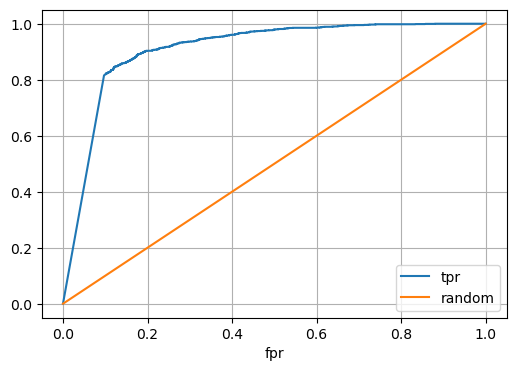

In [55]:
fpr, tpr, thr = roc_curve(y_valid, valid_predictions)
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
roc['random'] = roc['fpr'].copy()
roc['diff'] = roc['tpr'] - roc['fpr']
roc.plot(x='fpr', y=['tpr','random'], figsize=(6,4), grid=True)

In [56]:
roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)

In [57]:
roc.loc[0]

fpr       0.122295
tpr       0.846201
thr       0.387153
random    0.122295
diff      0.723906
Name: 0, dtype: float64

In [58]:
roc.query('thr < 0.55 & thr > 0.45 ')

,fpr,tpr,thr,random,diff
7,0.120282,0.843161,0.499659,0.120282,0.722879
8,0.119779,0.842553,0.542046,0.119779,0.722775
10,0.120282,0.842553,0.506882,0.120282,0.722271
13,0.121288,0.843161,0.463053,0.121288,0.721873


In [59]:
roc.loc[0,'thr']

0.3871532